In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import argparse

In [9]:
# --- Depthwise Separable Convolution = Depthwise conv + Pointwise conv ---
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution: 그룹 수 = 입력 채널 수
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                                   padding=1, groups=in_channels, bias=False)
        self.bn_depth = nn.BatchNorm2d(in_channels)
        # Pointwise convolution: 1x1 convolution으로 채널 결합
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,
                                   padding=0, bias=False)
        self.bn_point = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.bn_depth(self.depthwise(x)))
        x = self.relu(self.bn_point(self.pointwise(x)))
        return x


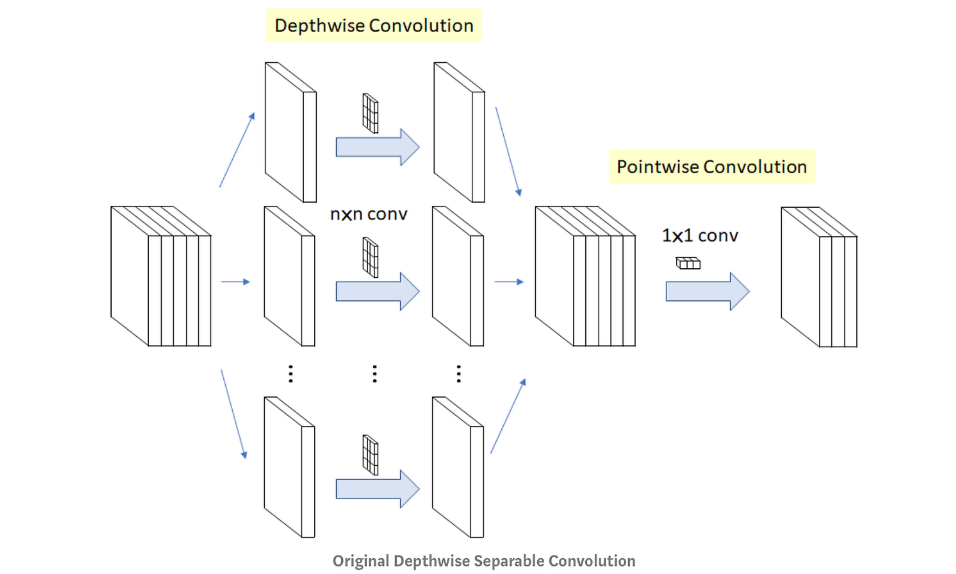

In [10]:
# --- 2. MobileNet 모델 정의 (MobileNet v1 구조 참고) ---
class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        # 초기 표준 Convolution: 3x3, stride 2
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Depthwise Separable Convolution 블록들을 순차적으로 구성
        self.dsconv = nn.Sequential(
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            # 5번 반복: 512 채널, stride 1
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1)
        )
        # Global average pooling 후 분류기 연결
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dsconv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
# --- 3. 이미지 전처리 함수 ---
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.2023, 0.1994, 0.2010]) 
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

In [12]:
# --- 4. 예측 함수 ---
def predict(model, image_tensor, device):
    model.eval()
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
    return probabilities

In [ ]:
# --- 5. Main 함수: 인자 처리 방식 수정 ---
def main(args_list=None):
    parser = argparse.ArgumentParser(description="PyTorch MobileNet Inference Example")
    parser.add_argument('--image_path', type=str, required=True, help="Input image path")
    parser.add_argument('--num_classes', type=int, default=10, help="class number 10")
    
    # args_list가 주어지면 그것을 인자로 사용, 아니면 실제 command line 인자를 사용
    if args_list is not None:
        args = parser.parse_args(args_list)
    else:
        args = parser.parse_args()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 모델 생성 및 디바이스 할당
    model = MobileNet(num_classes=args.num_classes).to(device)
    model.load_state_dict(torch.load('./models/best_model.pth', map_location=torch.device('cpu')))
    model.eval()  # 평가 모드로 전환
    
    # ------------------------------ 하나의 이미지 처리 방식 ------------------------------ 여러 이미지 입력 시 for문으로 변경
    # 이미지 로드 및 전처리
    image_tensor = load_and_preprocess_image(args.image_path)
    
    # 예측 수행
    probabilities = predict(model, image_tensor, device)
    
    # Top-5 결과 출력
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    print("Top 5 예측 결과:")
    for i in range(top5_prob.size(1)):
        print(f"클래스 {top5_catid[0][i].item()}: 확률 {top5_prob[0][i].item():.4f}")
    #-------------------------------------------------------------------------------------

In [14]:
# Notebook 등에서 사용할 때는 아래와 같이 인자 리스트를 전달
if __name__ == '__main__':
    main(args_list=["--image_path", "./data/deer_picture.jpg"])

Using device: cpu
Top 5 예측 결과:
클래스 4: 확률 0.9937
클래스 2: 확률 0.0058
클래스 5: 확률 0.0003
클래스 0: 확률 0.0001
클래스 3: 확률 0.0001


C:\Users\Admin\AppData\Local\Temp\ipykernel_352\2951357000.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/best_model.pth', m

| 라벨(Index) | 클래스 이름(Class Name) |
|:----------:|:-----------------------:|
| 0          | airplane               |
| 1          | automobile             |
| 2          | bird                   |
| 3          | cat                    |
| 4          | deer                   |
| 5          | dog                    |
| 6          | frog                   |
| 7          | horse                  |
| 8          | ship                   |
| 9          | truck                  |